# Исследование надежности заемщиков


Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов. Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Откроем таблицу и изучим общую информацию о данных 
## Выполним предобработку данных

Загрузим библиотеки и данные

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('/datasets/data.csv')
except:
    data = pd.read_csv('/Users/a0000/Documents/Analitic/All_projects/project1_bank/datasets/data.csv')    

In [3]:
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Изучим информацию о датафрейме

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

**Промежуточный вывод:** В данных есть пропуски, так же нужно исправить тип некоторых столбцов

Cтолбец с пропущенными значениями — total_income — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца income_type. Например, у человека с типом занятости сотрудник пропуск в столбце total_income должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке. таким артефактом будет отрицательное количество дней трудового стажа в столбце days_employed. Для реальных данных это нормально. Обработайте значения в этом столбце: замените все отрицательные значения положительными с помощью метода abs()

In [7]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведите медианное значение трудового стажа days_employed в днях.

In [8]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставьте их как есть.

Заполним пропуски в столбце days_employed медианными значениями по каждого типа занятости income_type

In [9]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Выведем перечень уникальных значений столбца children.

In [10]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

В столбце children есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма data

In [11]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [12]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

Заменим вещественный тип данных в столбце total_income на целочисленный с помощью метода astype()

In [13]:
data['total_income'] = data['total_income'].astype(int)

Обработаем неявные дубликаты в столбце education. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру.

In [14]:
data['education'] = data['education'].str.lower()

Выведем на экран количество строк-дубликатов в данных. Если такие строки присутствуют, удалите их.

In [15]:
data.duplicated().sum()

71

In [16]:
data = data.drop_duplicates()

На основании диапазонов, указанных ниже, создадим в датафрейме data столбец total_income_category с категориями:

- 0–30000 — 'E';
- 30001–50000 — 'D';
- 50001–200000 — 'C';
- 200001–1000000 — 'B';
- 1000001 и выше — 'A'.

Например, кредитополучателю с доходом 25000 нужно назначить категорию 'E', а клиенту, получающему 235000, — 'B'. Используйте собственную функцию с именем categorize_income() и метод apply().

In [17]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [18]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведем на экран перечень уникальных целей взятия кредита из столбца `purpose`.

In [19]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создим функцию, которая на основании данных из столбца purpose сформирует новый столбец purpose_category, в который войдут следующие категории:

- 'операции с автомобилем',
- 'операции с недвижимостью',
- 'проведение свадьбы',
- 'получение образования'.

Например, если в столбце purpose находится подстрока 'на покупку автомобиля', то в столбце purpose_category должна появиться строка 'операции с автомобилем'.

Используем собственную функцию с именем categorize_purpose() и метод apply(). 

In [20]:
# создайте функцию categorize_purpose()
purpose = data['purpose']
def categorize_purpose(purpose):
    if 'авто' in purpose:
        return('операции с автомобилем')
    if 'жи' in purpose:
        return('операции с недвижимостью')
    if 'сва' in purpose:
        return('проведение свадьбы')
    if 'обра' in purpose:
        return('получение образования')

In [21]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

In [22]:
data.head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью


### Есть ли зависимость между количеством детей и возвратом кредита в срок?

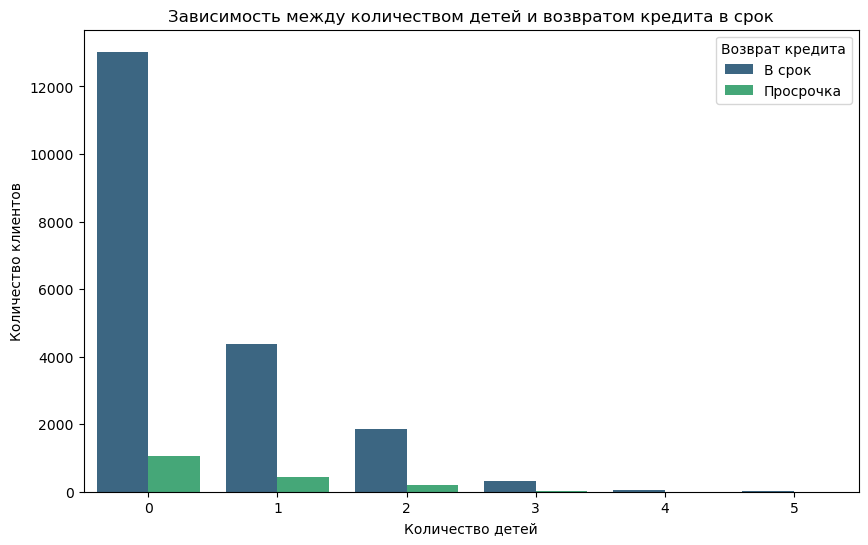

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x='children', hue='debt', data=data, palette='viridis')
plt.title('Зависимость между количеством детей и возвратом кредита в срок')
plt.xlabel('Количество детей')
plt.ylabel('Количество клиентов')
plt.legend(title='Возврат кредита', labels=['В срок', 'Просрочка'])
plt.show()

In [27]:
debt_counts = data.groupby(['children', 'debt']).size().unstack(fill_value=0)
debt_counts['debt_procent'] = round(debt_counts[1] / (debt_counts[0] + debt_counts[1]) * 100,2)
debt_counts

debt,0,1,debt_procent
children,,,
0,13028,1063,7.54
1,4364,444,9.23
2,1858,194,9.45
3,303,27,8.18
4,37,4,9.76
5,9,0,0.00


Бездетные заемщики (0 детей): имеют самый низкий процент невозврата кредита (7.54%). Это может говорить о том, что у людей без детей меньше финансовых обязательств, и они могут быть более ответственными в финансовом планировании.

Заемщики с 1 и 2 детьми: процент невозврата кредита выше (9.23% и 9.45% соответственно) по сравнению с бездетными. Увеличение финансовой нагрузки на семью с ростом числа детей может способствовать увеличению вероятности просрочек по кредитам.

Заемщики с 3 детьми: показывают более низкий процент невозврата (8.18%) по сравнению с теми, у кого 1 или 2 ребенка. Это может быть связано с получением государственной поддержки или лучшим финансовым планированием в семьях с тремя детьми.

Заемщики с 4 детьми: демонстрируют высокий процент невозврата (9.76%), что может быть связано с увеличением финансовой нагрузки на семью.

Заемщики с 5 детьми: не имеют случаев невозврата кредита, но общее количество таких заемщиков очень мало (всего 9), что делает недостаточные выводы для этой категории.

**Вывод**:Изучив данные приходим к выводу что,с увеличением количества детей увеличивается и процент невозврата кредита, за исключением семьи с 3 детьми).

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

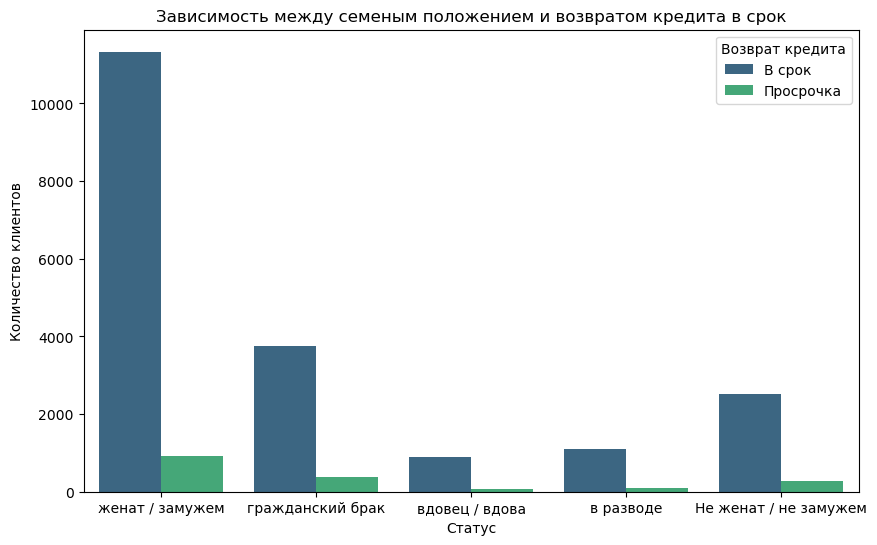

In [43]:
plt.figure(figsize=(10, 6))
sns.countplot(x='family_status', hue='debt', data=data, palette='viridis')
plt.title('Зависимость между семеным положением и возвратом кредита в срок')
plt.xlabel('Статус')
plt.ylabel('Количество клиентов')
plt.legend(title='Возврат кредита', labels=['В срок', 'Просрочка'])
plt.show()

In [40]:
debt_counts = data.groupby(['family_status', 'debt']).size().unstack(fill_value=0)
debt_counts['debt_procent'] = round(debt_counts[1] / (debt_counts[0] + debt_counts[1]) * 100,2)
debt_counts.sort_values(by='debt_procent', ascending=True)

debt,0,1,debt_procent
family_status,,,
вдовец / вдова,888,63,6.62
в разводе,1105,84,7.06
женат / замужем,11334,927,7.56
гражданский брак,3749,385,9.31
Не женат / не замужем,2523,273,9.76


**Вывод:** Люди имеющие статус "в разводе, вдовец / вдова, женат / замужем" имеют более высокий процент своевременного возврата кредитов, это может свидетельствовать о том, что у них присутвует определенная стабильность в финансовое поведение по сравнению с теми, кто имеет статус "Не женат / не замужем, гражданский брак"

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

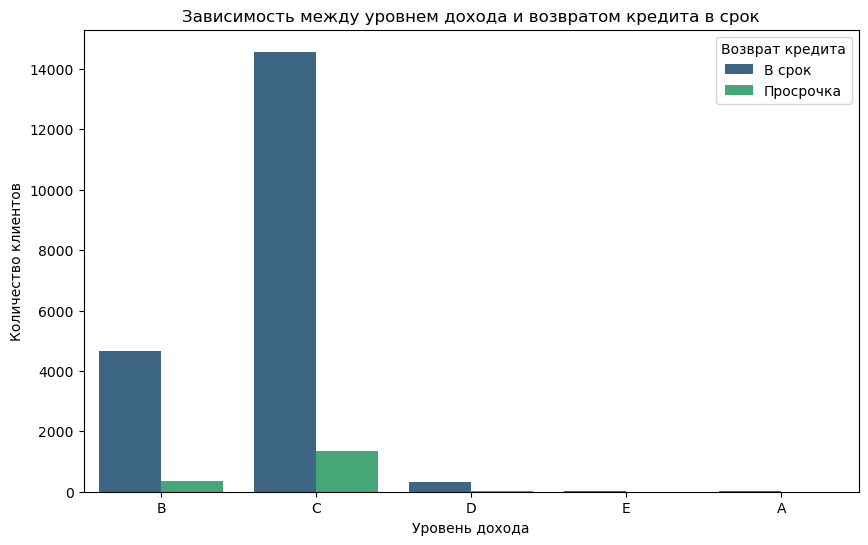

In [50]:
plt.figure(figsize=(10, 6))
sns.countplot(x='total_income_category', hue='debt', data=data, palette='viridis')
plt.title('Зависимость между уровнем дохода и возвратом кредита в срок')
plt.xlabel('Уровень дохода')
plt.ylabel('Количество клиентов')
plt.legend(title='Возврат кредита', labels=['В срок', 'Просрочка'])
plt.show()

In [47]:
debt_counts = data.groupby(['total_income_category', 'debt']).size().unstack(fill_value=0)
debt_counts['debt_procent'] = round(debt_counts[1] / (debt_counts[0] + debt_counts[1]) * 100,2)
debt_counts

debt,0,1,debt_procent
total_income_category,,,
A,23,2,8.00
B,4660,354,7.06
C,14568,1353,8.50
D,328,21,6.02
E,20,2,9.09


**Вывод:** Категория D "30001–50000" имеет самый низкий процент невозврата кредитов. Это может указывать на то, что заемщики в этой категории управляют своими финансами достаточно осторожно, возможно, из-за ограниченных ресурсов, что приводит к более ответственному отношению к долгам.

Категория C - "50001–200000", с другой стороны, показывает более высокий процент невозврата. Это может быть связано с тем, что у заемщиков в этой категории, несмотря на сравнительно приличный доход, может быть больше обязательств или менее строгий финансовый контроль, что приводит к финансовым трудностям.

Категория B - "200001–1000000" занимает промежуточное положение с процентом невозврата 7.06%. Заемщики в этой категории, вероятно, имеют лучшее кредитное образование и доступ к финансовым инструментам, что способствует более успешному управлению кредитами.

При анализе данных о невозврате кредитов по категориям A - "1000001 и выше" и E - "0–30000" стоит также учитывать, что оценка может быть затруднена из-за относительно малого размера выборки. Малый объем данных в категориях может приводить к тому, что результаты статистически менее устойчивы и могут быть искажены несколькими аномальными случаями или не отражать общую тенденцию.

### Как разные цели кредита влияют на его возврат в срок?

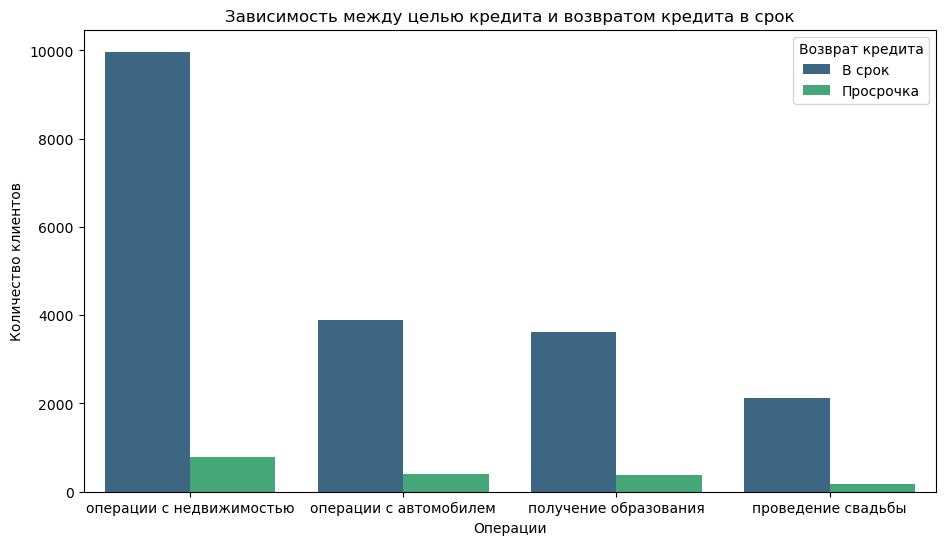

In [59]:
plt.figure(figsize=(11, 6))
sns.countplot(x='purpose_category', hue='debt', data=data, palette='viridis')
plt.title('Зависимость между целью кредита и возвратом кредита в срок')
plt.xlabel('Операции')
plt.ylabel('Количество клиентов')
plt.legend(title='Возврат кредита', labels=['В срок', 'Просрочка'])
plt.show()

In [52]:
debt_counts = data.groupby(['purpose_category', 'debt']).size().unstack(fill_value=0)
debt_counts['debt_procent'] = round(debt_counts[1] / (debt_counts[0] + debt_counts[1]) * 100,2)
debt_counts

debt,0,1,debt_procent
purpose_category,,,
операции с автомобилем,3879,400,9.35
операции с недвижимостью,9971,780,7.26
получение образования,3619,369,9.25
проведение свадьбы,2130,183,7.91


**Вывод:** Заемщики которые взяли кредит категории "операции с недвижимостью и проведение свадьбы" имеют более высокий процент своевременного возврата кредита по сравнению с теми, кто имеет уровень дохода категории "операции с автомобилем, получение образования" , это может означать более ответственному отношению к долгам и лучшую финансовую стабильность.

### Приведите возможные причины появления пропусков в исходных данных.

Ошибки при вводе данных, Технические проблемы при сборе данных, Ограничения при сборе данных, Недоступность данных, Исключение данных из анализа.

### Объясните, почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.

Заполнять пропуски медианным значением — лучшее решение для количественных переменных, так как одно значение может быть 1, а другое 100, и среднее между ними будет 50.5, из-за чего может быть получена в дальнейшем неверная информация.

**Вывод:**

**Портрет идеального клиента**

Семейное положение: Женат / Замужем, Вдовец / Вдова или Разведен(а). Эти категории чаще всего демонстрируют высокий процент своевременного возврата кредитов, что указывает на финансовую стабильность и ответственность.

Количество детей: Бездетные. Люди без детей имеют самый низкий процент невозврата кредита (7.54%), что может свидетельствовать о меньших финансовых обязательствах и более строгом финансовом планировании.

Категория дохода: Высокий (категория D). Эта группа показала самый низкий процент невозврата кредитов, что может быть связано с осторожным управлением ограниченными ресурсами.

Цель кредита: Операции с недвижимостью или проведение свадьбы. Заемщики, взявшие кредиты на эти цели, имеют выше процент своевременного возврата кредитов.

**Портрет нежелательного клиента**

Семейное положение: Не женат / Не замужем или Гражданский брак. Эти категории показывают более высокий процент невозврата кредитов, что может указывать на менее стабильное финансовое положение.

Количество детей: 4 ребенка. Заемщики с четырьмя детьми демонстрируют высокий процент невозврата кредитов (9.76%), что скорее всего связано с увеличением финансовой нагрузки.

Категория дохода: Средний (категория C). Заемщики в этой категории показывают более высокий процент невозврата, возможно, из-за большего количества финансовых обязательств и менее строгого финансового контроля.

Цель кредита: Операции с автомобилем или получение образования. Эти цели кредитования связаны с более высоким процентом невозврата, что может отражать менее ответственное отношение к долгам и финансовые трудности.

**3. Итоговые рекомендации для заказчика по сбору данных и скорингу**

**Расширение и Углубление Сбора Данных:**

**Демографическая информация:** Уделите особое внимание сбору подробной информации о семейном положении и количестве детей заемщика. Эти параметры показали значительное влияние на вероятность невозврата кредитов.

**Финансовые данные**: Собирайте более детализированную информацию о доходах и регулярных расходах заемщиков, включая тип дохода (постоянный, временный) и источники финансовой поддержки (например, государственные выплаты).

**Цели кредитования:** Фиксируйте и анализируйте цели кредитования более тщательно, поскольку это существенно влияет на риск невозврата.

**Улучшение Моделей Скоринга:**

**Поведенческие факторы:** Включите анализ платежной дисциплины по Количеству банковских займов за весь период жизни;
Количеству отказов от других банков и микрофинансовых организаций, Сумму, которую заемщик выплатили без просрочек.

**Анкета потенциального заёмщика:** Добавьте адрес проживания. По статистике люди из более обеспеченных регионов лучше выплачивают кредит, чем жители неблагополучных областей страны;